# Load Data

In [6]:
import numpy as np
import pandas as pd

# Load the training and test datasets
X_train = pd.read_csv('/kaggle/input/weatheraus/weatherAUS_X_train.csv')
y_train = pd.read_csv('/kaggle/input/weatheraus/weatherAUS_y_train.csv')
X_test = pd.read_csv('/kaggle/input/weatheraus/weatherAUS_X_test.csv')
y_test = pd.read_csv('/kaggle/input/weatheraus/weatherAUS_y_test.csv')

# Data Preprocessing

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#- Had to figure out what features to drop and how to convert the Yes and No 
#- for rain into numerical values.
#- Dropped 'Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'. 
#- Next, had to figure out how to deal with NaN values. Went with filling them with the mean,
#- remove rows where the y dataset had NaN values, and match new x dataset with y.

# Converting 'yes' and 'no' to numerical values.
X_train['RainToday'] = X_train['RainToday'].replace({'Yes': 1, 'No': 0})
X_test['RainToday'] = X_test['RainToday'].replace({'Yes': 1, 'No': 0})
y_train['RainTomorrow'] = y_train['RainTomorrow'].replace({'Yes': 1, 'No': 0})
y_test['RainTomorrow'] = y_test['RainTomorrow'].replace({'Yes': 1, 'No': 0})

# Drop rows with NaN in y data and match X with it.
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index] 
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index] 

# Variables
features_to_drop = ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
X_train = X_train.drop(features_to_drop, axis=1)
X_test = X_test.drop(features_to_drop, axis=1)

# Fill in NaN values with mean.
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

#- Need to use ravel to change the shape of the dataset because models
#- expect 1 dimensional array, not columns.

# Change the shape of y dataset.
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

/tmp/ipykernel_33/1264276679.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train['RainToday'] = X_train['RainToday'].replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_33/1264276679.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test['RainToday'] = X_test['RainToday'].replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_33/1264276679.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

# Building the Models

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_predictions = dt_model.predict(X_test_scaled)

# Support Vector Machine
svm_model = SVC(random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_predictions = svm_model.predict(X_test_scaled)

# Multi-layer Perceptron
mlp_model = MLPClassifier(random_state=42)
mlp_model.fit(X_train_scaled, y_train)
mlp_predictions = mlp_model.predict(X_test_scaled)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)

# Naïve Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
nb_predictions = nb_model.predict(X_test_scaled)

# Initial Test for Accuracies

In [9]:
print("DT Accuracy:", accuracy_score(y_test, dt_predictions))
print("Classification Report:", classification_report(y_test, dt_predictions))

print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("Classification Report:", classification_report(y_test, svm_predictions))

print("MLP Accuracy:", accuracy_score(y_test, mlp_predictions))
print("Classification Report:", classification_report(y_test, mlp_predictions))

print("LR Accuracy:", accuracy_score(y_test, lr_predictions))
print("Classification Report:", classification_report(y_test, lr_predictions))

print("NB Accuracy:", accuracy_score(y_test, nb_predictions))
print("Classification Report:", classification_report(y_test, nb_predictions))

DT Accuracy: 0.7824985931344963
Classification Report:               precision    recall  f1-score   support

         0.0       0.86      0.86      0.86     22012
         1.0       0.52      0.53      0.52      6420

    accuracy                           0.78     28432
   macro avg       0.69      0.69      0.69     28432
weighted avg       0.78      0.78      0.78     28432

SVM Accuracy: 0.8467923466516601
Classification Report:               precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     22012
         1.0       0.77      0.46      0.57      6420

    accuracy                           0.85     28432
   macro avg       0.81      0.71      0.74     28432
weighted avg       0.84      0.85      0.83     28432

MLP Accuracy: 0.8491840180078785
Classification Report:               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     22012
         1.0       0.72      0.54      0.62      6420

    accuracy   

# Improving the Models

## Improving Decision Tree Model using GridSearch

In [10]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]     
}

# Create the grid search model
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=1)
dt_grid.fit(X_train_scaled, y_train)

# Best parameters found
print("Best parameters for Decision Tree:", dt_grid.best_params_)

# Make predictions.
dt_improved_model = dt_grid.best_estimator_
dt_predictions = dt_improved_model.predict(X_test_scaled)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [11]:
# Evaluate improved DT model.
print("Accuracy of Decision Tree:", accuracy_score(y_test, dt_predictions))
print("Classification Report for Decision Tree:\n", classification_report(y_test, dt_predictions))

Accuracy of Decision Tree: 0.8352560495216658
Classification Report for Decision Tree:
               precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     22012
         1.0       0.70      0.47      0.57      6420

    accuracy                           0.84     28432
   macro avg       0.78      0.71      0.73     28432
weighted avg       0.82      0.84      0.82     28432



## Improving SVM using RandomizedSearch


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Setup pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42, probability=True))
])

# Define a smaller parameter grid or use random distributions
param_distributions = {
    'svc__C': np.logspace(-3, 2, 6),  # Logarithmically spaced values
    'svc__kernel': ['rbf'],  # Consider focusing on one type of kernel
    'svc__gamma': ['scale', 'auto']
}

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled[:17500], y_train[:17500])  # Use about 15% of the dataset.

# Best parameters found
print("Best parameters:", random_search.best_params_)

# Make Predictions
svm_improved_model = random_search.best_estimator_
svm_predictions = svm_improved_model.predict(X_test_scaled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__C': 1.0}


In [30]:
# Evaluate improved SVM model.
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("Classification Report:", classification_report(y_test, svm_predictions))

SVM Accuracy: 0.8432751828925155
Classification Report:               precision    recall  f1-score   support

         0.0       0.86      0.95      0.90     22012
         1.0       0.74      0.47      0.58      6420

    accuracy                           0.84     28432
   macro avg       0.80      0.71      0.74     28432
weighted avg       0.83      0.84      0.83     28432



## Improving MLP using L2 Regularization, Learning Rate Reduction, and Adam Optimizer

In [44]:
# Create a pipeline with scaling and an MLP classifier
mlp_model = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32, 16),  # Three layers with 64, 32, and 16 neurons respectively
        activation='relu',               # ReLU activation function
        solver='adam',                   # Adam optimizer
        alpha=0.001,                     # L2 penalty (regularization term), compromise between layers
        batch_size='auto',               # Mini-batch size, 'auto' means min(200, n_samples)
        learning_rate='adaptive',        # Keeps the learning rate constant as long as training loss decreases
        max_iter=200,                    # Maximum number of epochs
        tol=1e-4,
        n_iter_no_change=10,
        early_stopping=True,             # Stop early once the model has hit convergence.
        random_state=42,
        verbose=True
    ))
])

# Fit the model to the training data
mlp_model.fit(X_train_scaled, y_train)

# Make predictions
mlp_predictions = mlp_model.predict(X_test_scaled)

Iteration 1, loss = 0.38394230
Validation score: 0.846005
Iteration 2, loss = 0.35141660
Validation score: 0.849257
Iteration 3, loss = 0.34731938
Validation score: 0.849521
Iteration 4, loss = 0.34493334
Validation score: 0.849433
Iteration 5, loss = 0.34293738
Validation score: 0.850400
Iteration 6, loss = 0.34169991
Validation score: 0.850927
Iteration 7, loss = 0.33993438
Validation score: 0.851191
Iteration 8, loss = 0.33842493
Validation score: 0.851279
Iteration 9, loss = 0.33781418
Validation score: 0.851894
Iteration 10, loss = 0.33661445
Validation score: 0.850224
Iteration 11, loss = 0.33510616
Validation score: 0.849960
Iteration 12, loss = 0.33427949
Validation score: 0.851103
Iteration 13, loss = 0.33376922
Validation score: 0.851367
Iteration 14, loss = 0.33314468
Validation score: 0.851367
Iteration 15, loss = 0.33244946
Validation score: 0.851806
Iteration 16, loss = 0.33170474
Validation score: 0.851806
Iteration 17, loss = 0.33101921
Validation score: 0.852597
Iterat

In [46]:
# Evaluate improved MLP model.

mlp_class_labels = (mlp_predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1 based on threshold
print("MLP Accuracy:", accuracy_score(y_test, mlp_class_labels))
print("Classification Report:", classification_report(y_test, mlp_class_labels))


MLP Accuracy: 0.8497819358469331
Classification Report:               precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     22012
         1.0       0.74      0.51      0.61      6420

    accuracy                           0.85     28432
   macro avg       0.81      0.73      0.76     28432
weighted avg       0.84      0.85      0.84     28432



## Improving Logistic Regression using RandomizedSearchCV

In [16]:
# Pipeline for scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# Parameter distributions for RandomizedSearchCV
param_distributions = {
    'logreg__C': np.logspace(-4, 4, 20),  # Regularization strength
    'logreg__penalty': ['l1', 'l2']       # Type of regularization
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=100, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

# Fit the model using best estimator
lr_improved_model = random_search.best_estimator_
lr_predictions = lr_improved_model.predict(X_test_scaled)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [17]:
# Evaluate improved LR model.
print("LR Accuracy:", accuracy_score(y_test, lr_predictions))
print("Classification Report:", classification_report(y_test, lr_predictions))

LR Accuracy: 0.8404614518851998
Classification Report:               precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     22012
         1.0       0.72      0.49      0.58      6420

    accuracy                           0.84     28432
   macro avg       0.79      0.72      0.74     28432
weighted avg       0.83      0.84      0.83     28432



## Improving Naïve Bayes using Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Use Random Forest for feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
importances = rf.feature_importances_

# Select top features
indices = np.argsort(importances)[-10:]  # top 10 features
X_train_reduced = X_train_scaled[:, indices]
X_test_reduced = X_test_scaled[:, indices]

# Naive Bayes on selected features
nb_model = GaussianNB()
nb_model.fit(X_train_reduced, y_train)
nb_predictions = nb_model.predict(X_test_reduced)

In [19]:
# Evaluate improved nb_model.
print("NB Accuracy:", accuracy_score(y_test, nb_predictions))
print("Classification Report:", classification_report(y_test, nb_predictions))

NB Accuracy: 0.8218908272369162
Classification Report:               precision    recall  f1-score   support

         0.0       0.86      0.91      0.89     22012
         1.0       0.63      0.50      0.56      6420

    accuracy                           0.82     28432
   macro avg       0.75      0.71      0.72     28432
weighted avg       0.81      0.82      0.81     28432



# Evaluate the Models


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define a function to evaluate models
def evaluate_model(model, X_test, y_test, threshold=0.5):
    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > threshold).astype(int)
    
    # Accuracy, Precision, Recall, and F1 Score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC Curve and AUC
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plotting ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return accuracy, precision, recall, f1

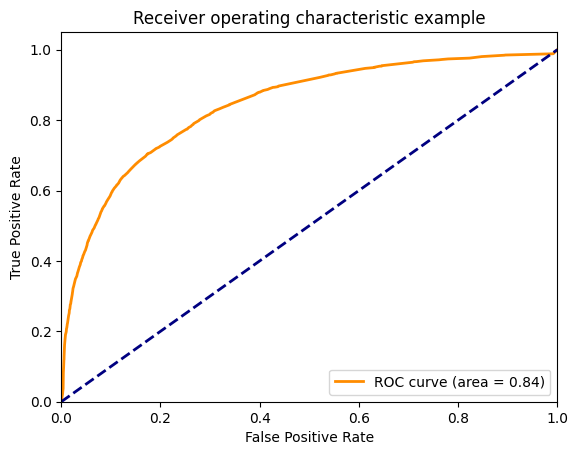

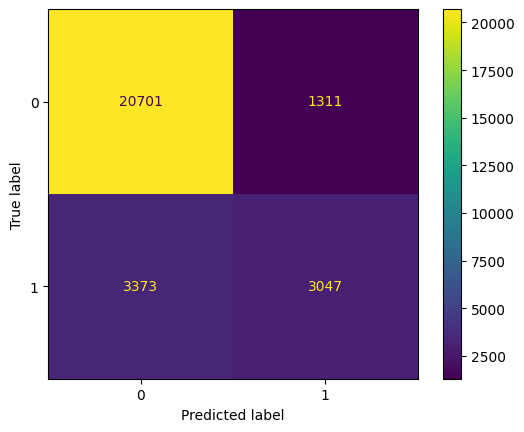

Accuracy: 0.8352560495216658
Precision: 0.6991739329967875
Recall: 0.4746105919003115
F1 Score: 0.5654110224531452


In [33]:
# Re-evaluate DT model.
accuracy, precision, recall, f1 = evaluate_model(dt_improved_model, X_test_scaled, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

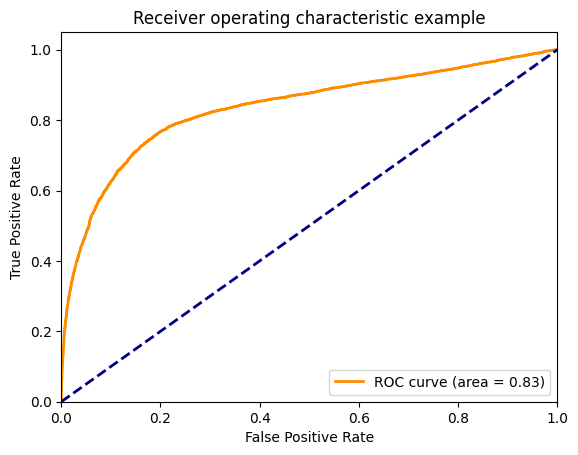

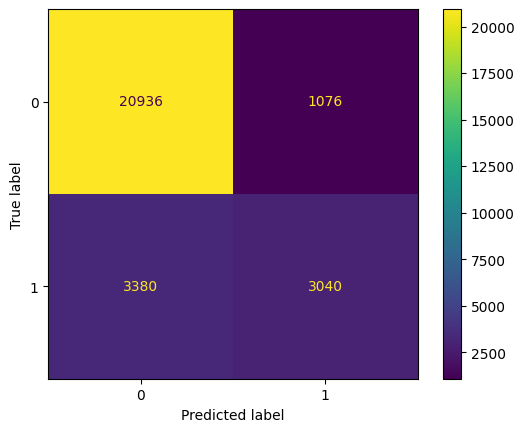

Accuracy: 0.8432751828925155
Precision: 0.738581146744412
Recall: 0.4735202492211838
F1 Score: 0.5770690964312832


In [31]:
# Re-evaluate SVM model.
accuracy, precision, recall, f1 = evaluate_model(svm_improved_model, X_test_scaled, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

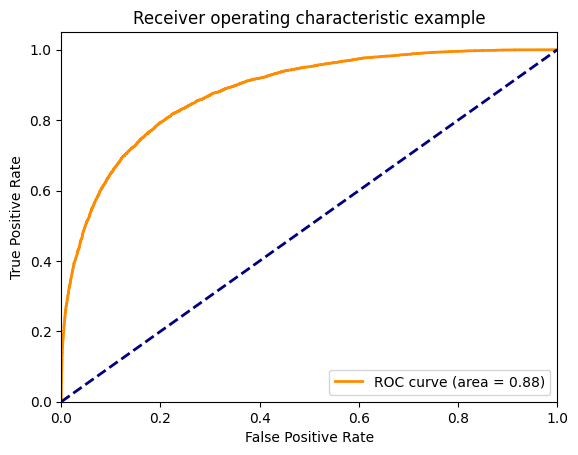

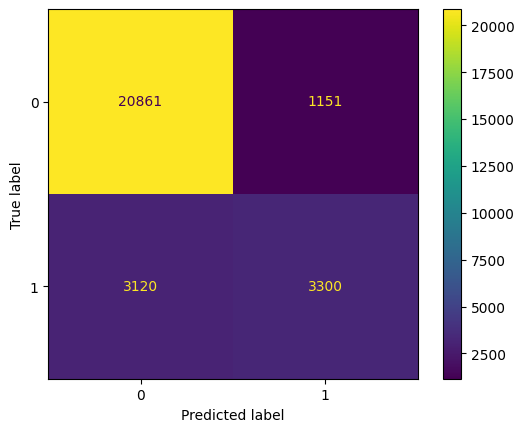

Accuracy: 0.8497819358469331
Precision: 0.7414064255223545
Recall: 0.514018691588785
F1 Score: 0.6071198601784564


In [49]:
# Re-evaluate MLP model.
accuracy, precision, recall, f1 = evaluate_model(mlp_model, X_test_scaled, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

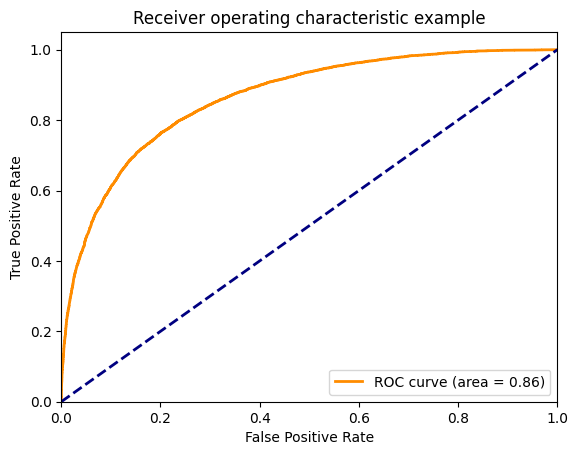

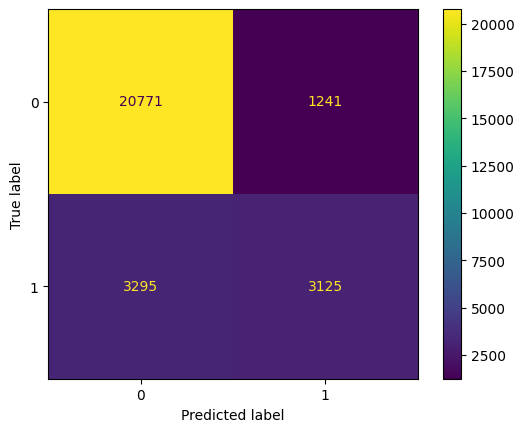

Accuracy: 0.8404614518851998
Precision: 0.7157581310123683
Recall: 0.4867601246105919
F1 Score: 0.5794548488781754


In [37]:
# Re-evaluate LR model.
accuracy, precision, recall, f1 = evaluate_model(lr_improved_model, X_test_scaled, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

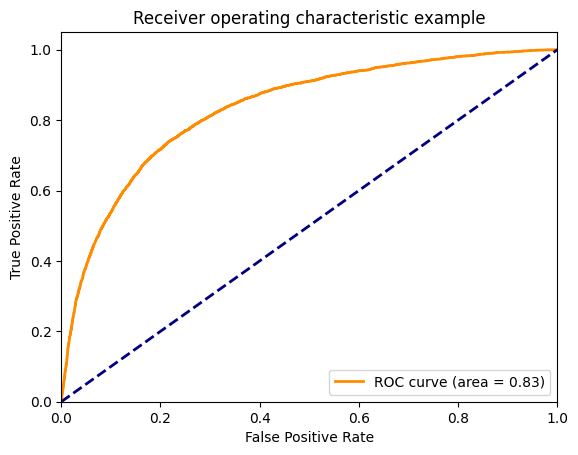

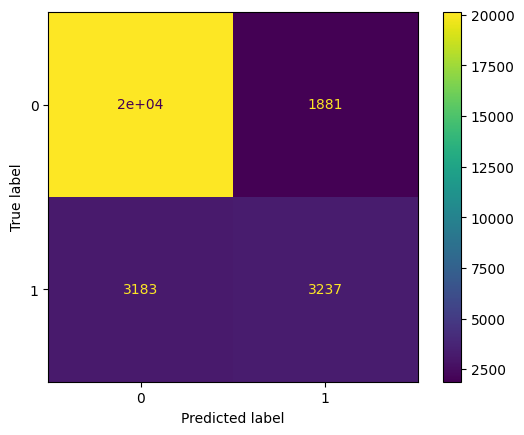

Accuracy: 0.8218908272369162
Precision: 0.6324736225087925
Recall: 0.5042056074766356
F1 Score: 0.5611024440977639


In [38]:
# Re-evaluate NB model.
accuracy, precision, recall, f1 = evaluate_model(nb_model, X_test_reduced, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)